# Notes
* This is the original container. Contains test sets as well. https://github.com/abachaa/MTS-Dialog/tree/main
* There are 4 samples where the dialogue exceeds the maximum input token length. It probably doesn't matter too much, but let's remove ID = 1115. Set tokenizer to truncate from the left, since usually the start of the dialogue doesn't contain information (e.g. hello, how are you today? blah blah)
* I think it's okay to keep short sequences. We still want to be able to "summarize" short dialogues.

In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import datasets
from datasets import load_dataset, Dataset, Features, Value, Sequence
from sklearn.model_selection import train_test_split, StratifiedKFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth', 500)

In [38]:
ds = load_dataset("har1/MTS_Dialogue-Clinical_Note", streaming=False)
ds

DatasetDict({
    train: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue'],
        num_rows: 1301
    })
})

In [41]:
df = pd.DataFrame(ds['train'])
df['ID'].max()
# df['ID'] = list(range(len(df)))

1200

In [40]:
ds['train'] = datasets.Dataset.from_pandas(df)
ds

DatasetDict({
    train: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue'],
        num_rows: 1301
    })
})

In [7]:
type(ds['train'])

datasets.arrow_dataset.Dataset

# <u>Tokenize</u>

In [42]:
model_name = 'facebook/bart-base'
tokenizer = AutoTokenizer.from_pretrained(model_name, truncation_side='left')
type(tokenizer)

C:\ProgramData\anaconda3\envs\env_dl_cv_transformer_sentpiece\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


transformers.models.bart.tokenization_bart_fast.BartTokenizerFast

In [43]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
max_len = model.config.max_position_embeddings
print(f"Max model length: {max_len}")
del model

Max model length: 1024


In [44]:
def tokenize_function(examples, tokenizer, input_col, output_col, max_len, padding=False, truncation=False):
    # Tokenize a pair of sequences (input-output pair, e.g. for summarization)
    tokenized = tokenizer(
        examples[input_col],
        text_target=examples[output_col],   # target sequence
        padding=padding,
        truncation=truncation,
        return_tensors='np',
        return_length=True,
    )

    return tokenized

In [45]:
ds_tk = ds.map(lambda example: tokenize_function(example, tokenizer, 'dialogue', 'section_text', max_len), batched=True)
ds_tk

Map:   0%|          | 0/1301 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 1301
    })
})

# <u>EDA</u>

In [10]:
ds_df = pd.DataFrame(ds_tk['train'], columns=['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'length', 'labels'])
ds_df['output_token_len'] = ds_df['labels'].apply(lambda x: len(x))
# ds_df = ds_df.drop(columns=['labels'])
ds_df = ds_df.rename(columns={'length': 'input_token_len'})
ds_df.head()

,ID,section_header,section_text,dialogue,input_ids,input_token_len,labels,output_token_len
0,0,GENHX,"Symptoms: no fever, no chills, no cough, no co...",Doctor: What brings you back into the clinic t...,"[0, 41152, 35, 653, 3291, 47, 124, 88, 5, 8474...",174,"[0, 46994, 47629, 35, 117, 11696, 6, 117, 1855...",103
1,1,GENHX,"Symptoms: sudden onset headache, blurry vision...",Doctor: How're you feeling today? \nPatient: ...,"[0, 41152, 35, 1336, 214, 47, 2157, 452, 116, ...",382,"[0, 46994, 47629, 35, 7207, 23808, 19344, 6, 4...",74
2,2,GENHX,Symptoms: itching.\nDiagnosis: condylomas.\nHi...,"Doctor: Hello, miss. What is the reason for yo...","[0, 41152, 35, 20920, 6, 2649, 4, 653, 16, 5, ...",152,"[0, 46994, 47629, 35, 35188, 4, 50118, 29038, ...",46
3,3,MEDICATIONS,Symptoms: N/A.\r\nDiagnosis: N/A.\r\nHistory o...,Doctor: Are you taking any over the counter me...,"[0, 41152, 35, 3945, 47, 602, 143, 81, 5, 3231...",119,"[0, 46994, 47629, 35, 234, 73, 250, 4, 50121, ...",83
4,4,CC,"Symptoms: Burn, right arm.\r\nDiagnosis: N/A.\...","Doctor: Hi, how are you? \nPatient: I burned m...","[0, 41152, 35, 12289, 6, 141, 32, 47, 116, 143...",52,"[0, 46994, 47629, 35, 7960, 6, 235, 3124, 4, 5...",42


In [13]:
ds_df[ds_df['input_token_len'] < 2000]['output_token_len'].describe()

count    1300.000000
mean       65.933846
std        36.064696
min        18.000000
25%        41.000000
50%        54.000000
75%        78.000000
max       349.000000
Name: output_token_len, dtype: float64

## *<u>Section header mapping</u>*

1. fam/sochx [FAMILY HISTORY/SOCIAL HISTORY]
2. genhx [HISTORY of PRESENT ILLNESS]
3. pastmedicalhx [PAST MEDICAL HISTORY]
4. cc [CHIEF COMPLAINT]
5. pastsurgical [PAST SURGICAL HISTORY]
6. allergy
7. ros [REVIEW OF SYSTEMS]
8. medications
9. assessment
10. exam
11. diagnosis
12. disposition
13. plan
14. edcourse [EMERGENCY DEPARTMENT COURSE]
15. immunizations
16. imaging
17. gynhx [GYNECOLOGIC HISTORY]
18. procedures
19. other_history
20. labs

## *<u>Class Distribution</u>*

In [141]:
classes = ds_df['section_header'].value_counts()

Index(['FAM/SOCHX', 'GENHX', 'PASTMEDICALHX', 'CC', 'PASTSURGICAL', 'ROS',
       'ALLERGY', 'MEDICATIONS', 'ASSESSMENT', 'EXAM', 'DIAGNOSIS',
       'DISPOSITION', 'PLAN', 'EDCOURSE', 'IMMUNIZATIONS', 'IMAGING', 'GYNHX',
       'PROCEDURES', 'OTHER_HISTORY', 'LABS'],
      dtype='object', name='section_header')


<Axes: xlabel='section_header'>

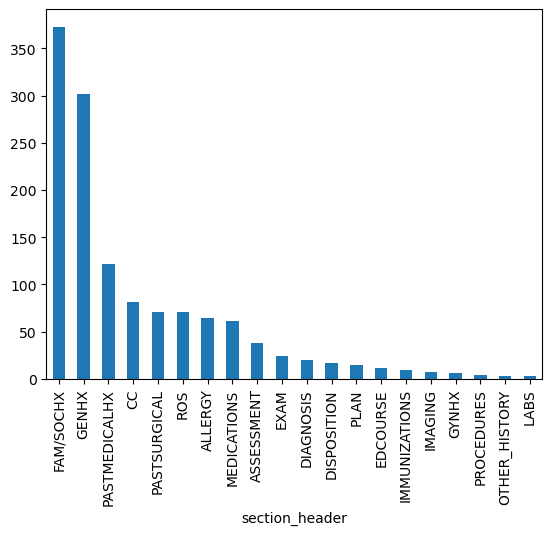

In [142]:
print(classes.index)
classes.plot.bar()

## *<u>Sequence Lengths</u>*

In [143]:
ds_df.loc[:,['input_token_len', 'output_token_len']].describe()

,input_token_len,output_token_len
count,1301.000000,1301.000000
mean,160.595696,66.113759
std,171.909344,36.630223
min,15.000000,18.000000
25%,56.000000,41.000000
50%,99.000000,54.000000
75%,203.000000,78.000000
max,2326.000000,349.000000


(0.0, 2500.0)

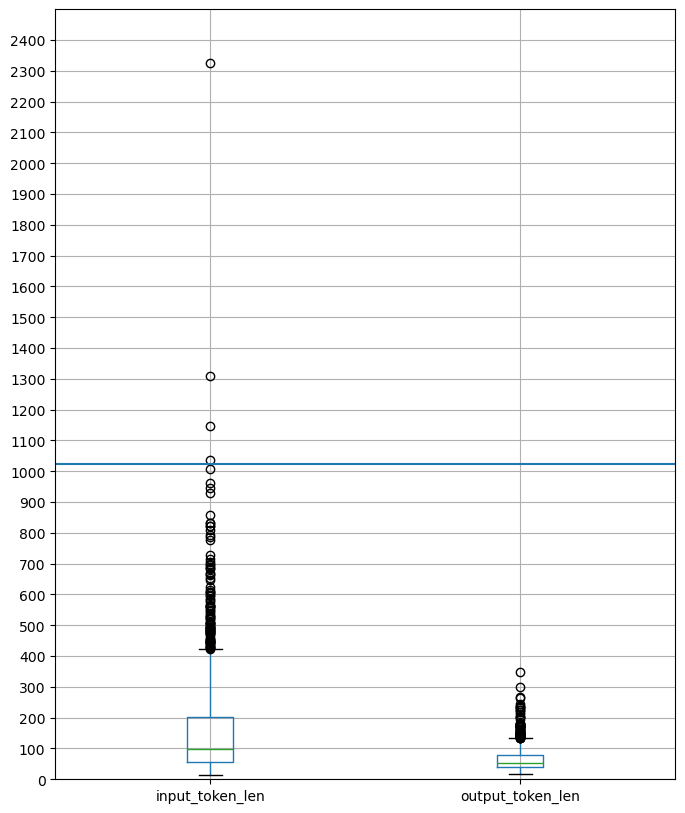

In [144]:
plt.figure(figsize=(8,10))
ds_df.boxplot(column=['input_token_len', 'output_token_len'])
plt.yticks(range(0,2500,100))
plt.axhline(1024)
plt.ylim([0, 2500])

### <u>**Long Input Sequences**</u>

In [145]:
ds_df[ds_df['input_token_len'] > max_len]

,ID,section_header,section_text,dialogue,input_ids,input_token_len,labels,output_token_len
297,297,GENHX,"Symptoms: Sharp lower back pain with radiation down right buttock and leg, muscle spasms in buttocks, worsened pain with sitting and stooping, difficulty sleeping due to pain\r\nDiagnosis: Lumbar radiculopathy\r\nHistory of Patient: Work-related injury involving lifting heavy objects, history of chronic back pain, unsuccessful treatment with muscle relaxers, lidocaine patches, opioids, epidural steroid injections, and chiropractic care\r\nPlan of Action: Further evaluation and treatment opti...","Doctor: Good afternoon, sir. Welcome in. Let's get started, how old are you?\nPatient: Good afternoon, doctor. I'm fifty two years old. \nDoctor: My nurse says that you're here for an independent evaluation, is that correct? \nPatient: Yes sir, that is. \nDoctor: Good, what do you do for a living? \nPatient: Right now, I'm a temporary employee for A B C A B C, I've worked for A B C D, too. \nDoctor: What do you do there?\nPatient: Mainly, I handle the loading and unloading of furniture and a...","[0, 41152, 35, 2497, 1390, 6, 21958, 4, 14826, 11, 4, 2780, 18, 120, 554, 6, 141, 793, 32, 47, 116, 50118, 18276, 4843, 35, 2497, 1390, 6, 3299, 4, 38, 437, 14865, 80, 107, 793, 4, 1437, 50118, 41152, 35, 1308, 9008, 161, 14, 47, 214, 259, 13, 41, 2222, 10437, 6, 16, 14, 4577, 116, 1437, 50118, 18276, 4843, 35, 3216, 21958, 6, 14, 16, 4, 1437, 50118, 41152, 35, 2497, 6, 99, 109, 47, 109, 13, 10, 1207, 116, 1437, 50118, 18276, 4843, 35, 5143, 122, 6, 38, 437, 10, 4667, 3200, 13, 83, 163, 230,...",1146,"[0, 46994, 47629, 35, 14765, 795, 124, 2400, 19, 13785, 159, 235, 17507, 3343, 8, 2985, 6, 8698, 2292, 34616, 11, 37312, 6, 23307, 2400, 19, 2828, 8, 20572, 12232, 6, 9600, 8416, 528, 7, 2400, 50121, 50118, 29038, 11244, 13310, 35, 226, 4179, 271, 13206, 636, 922, 31395, 50121, 50118, 38261, 9, 27690, 35, 6011, 12, 3368, 1356, 3329, 10201, 2016, 8720, 6, 750, 9, 7642, 124, 2400, 6, 15943, 1416, 19, 8698, 12327, 268, 6, 13431, 1975, 5193, 19054, 6, 16202, 6, 45263, 9799, 37614, 25747, 6, 8, 4...",123
399,399,GENHX,"Symptoms: RUE weakness, neck pain, atrophy and contractures of right hand, left sided paresthesia, upper extremity weakness (right worse than left), ataxia, nausea, vomiting, hyperreflexia, progressive proximal weakness of all four extremities, dysphagia, difficulty with manual dexterity, difficulty going down stairs.\r\nDiagnosis: intramedullary lesion at C2-3, extramedullary lesion at C6-7, hemangioblastoma.\r\nHistory of Patient: Started experiencing RUE weakness and neck pain in 7/93, in...","Doctor: Before we begin today, sir, I just need a few pieces of background information. I see here on my chart that you're thirty years old, is that correct? \nPatient: Yes doctor, that's correct. \nDoctor: Okay, and which hand is your dominant hand? \nPatient: I use my right hand for everything. \nDoctor: Now, take me through the timeline of your symptoms, please. When did everything start?\nPatient: I was doing well until July of nineteen ninety three. \nDoctor: What were your initial symp...","[0, 41152, 35, 3224, 52, 1642, 452, 6, 21958, 6, 38, 95, 240, 10, 367, 3745, 9, 3618, 335, 4, 38, 192, 259, 15, 127, 5966, 14, 47, 214, 16984, 107, 793, 6, 16, 14, 4577, 116, 1437, 50118, 18276, 4843, 35, 3216, 3299, 6, 14, 18, 4577, 4, 1437, 50118, 41152, 35, 8487, 6, 8, 61, 865, 16, 110, 7353, 865, 116, 1437, 50118, 18276, 4843, 35, 38, 304, 127, 235, 865, 13, 960, 4, 1437, 50118, 41152, 35, 978, 6, 185, 162, 149, 5, 10589, 9, 110, 5298, 6, 2540, 4, 520, 222, 960, 386, 116, 50118, 18276, ...]",1035,"[0, 46994, 47629, 35, 248, 9162, 8269, 6, 5397, 2400, 6, 35790, 16628, 8, 1355, 4123, 9, 235, 865, 6, 314, 26710, 181, 18759, 5065, 493, 6, 2853, 34867, 1571, 8269, 36, 4070, 3007, 87, 314, 238, 23, 3631, 493, 6, 27214, 6, 23600, 6, 8944, 13043, 14726, 493, 6, 8212, 43860, 16980, 8269, 9, 70, 237, 34867, 2192, 6, 44153, 1073, 493, 6, 9600, 19, 12769,

In [ ]:
IDs = [297, 399, 1096, 1115]
for ID in IDs:
    print(ID)
    print('')
    # print(ds_df[ds_df['ID'] == ID]['dialogue'].iloc[0])
    # print('')
    tk = tokenizer(ds_df[ds_df['ID'] == ID]['dialogue'].iloc[0], padding=False, truncation=True, max_length=max_len)
    decoded = tokenizer.decode(tk['input_ids'], skip_special_tokens=True)
    print(decoded)
    print('')
    print(ds_df[ds_df['ID'] == ID]['section_text'].iloc[0])
    print('-------------------------------------------------------------------')

### **<u>Short Input Sequences</u>**

In [155]:
# Output length is >= input length
print(ds_df[ds_df['input_token_len'] <= ds_df['output_token_len']].loc[:,['input_token_len', 'output_token_len']].describe())
ds_df[ds_df['input_token_len'] <= ds_df['output_token_len']]

       input_token_len  output_token_len
count       216.000000        216.000000
mean         32.212963         43.444444
std          11.718045         11.240983
min          15.000000         33.000000
25%          23.000000         37.000000
50%          31.000000         41.000000
75%          38.250000         46.000000
max          88.000000        148.000000


,ID,section_header,section_text,dialogue,input_ids,input_token_len,labels,output_token_len
7,7,ALLERGY,Symptoms: N/A.\r\nDiagnosis: N/A.\r\nHistory of Patient: No known drug allergies.\r\nPlan of Action: N/A.\r\n,Doctor: Any know drug allergies? \nPatient: No.,"[0, 41152, 35, 5053, 216, 1262, 26331, 116, 1437, 50118, 18276, 4843, 35, 440, 4, 2]",16,"[0, 46994, 47629, 35, 234, 73, 250, 4, 50121, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 4, 50121, 50118, 38261, 9, 27690, 35, 440, 684, 1262, 26331, 4, 50121, 50118, 35351, 9, 5828, 35, 234, 73, 250, 4, 50121, 50118, 2]",42
19,19,MEDICATIONS,Symptoms: N/A.\nDiagnosis: N/A.\nHistory of Patient: N/A.\nPlan of Action: N/A.\n,Doctor: Is he currently taking any medication? \nGuest_family: No.,"[0, 41152, 35, 1534, 37, 855, 602, 143, 8456, 116, 1437, 50118, 45721, 1215, 12368, 35, 440, 4, 2]",19,"[0, 46994, 47629, 35, 234, 73, 250, 4, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 4, 50118, 38261, 9, 27690, 35, 234, 73, 250, 4, 50118, 35351, 9, 5828, 35, 234, 73, 250, 4, 50118, 2]",37
23,23,ALLERGY,"Symptoms: N/A.\r\nDiagnosis: N/A.\r\nHistory of Patient: Allergic to Penicillin, no known allergies to other drugs.\r\nPlan of Action: N/A.\r\n","Doctor: Are you allergic to anything?\nPatient: Yes, I am allergic to Penicillin.\nDoctor: Any other drugs that you could be allergic to?\nPatient: Nope that is all.\nDoctor: Okay.","[0, 41152, 35, 3945, 47, 28349, 7, 932, 116, 50118, 18276, 4843, 35, 3216, 6, 38, 524, 28349, 7, 4676, 636, 36817, 4, 50118, 41152, 35, 5053, 97, 2196, 14, 47, 115, 28, 28349, 7, 116, 50118, 18276, 4843, 35, 37712, 14, 16, 70, 4, 50118, 41152, 35, 8487, 4, 2]",51,"[0, 46994, 47629, 35, 234, 73, 250, 4, 50121, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 4, 50121, 50118, 38261, 9, 27690, 35, 404, 44858, 7, 4676, 636, 36817, 6, 117, 684, 26331, 7, 97, 2196, 4, 50121, 50118, 35351, 9, 5828, 35, 234, 73, 250, 4, 50121, 50118, 2]",51
24,24,ASSESSMENT,"Symptoms: Hypoglycemia, hypertension, renal insufficiency.\r\nDiagnosis: N/A.\r\nHistory of Patient: Poor renal sufficiency possibly due to dehydration or diabetic nephropathy, high blood pressure, hypoglycemia due to irregular meal consumption.\r\nPlan of Action: N/A.\r\n","Guest_clinician: What brought them in today? \nDoctor: Poor renal sufficiency, possibly due to dehydration or diabetic nephropathy. She also has high blood pressure and low blood sugar as a result of missing meals regularly.","[0, 45721, 1215, 3998, 179, 14932, 35, 653, 1146, 106, 11, 452, 116, 1437, 50118, 41152, 35, 11253, 39729, 2628, 45326, 6, 3544, 528, 7, 33229, 50, 33560, 3087, 3792, 6884, 17543, 4, 264, 67, 34, 239, 1925, 1164, 8, 614, 1925, 4696, 25, 10, 898, 9, 1716, 7317, 4595, 4, 2]",52,"[0, 46994, 47629, 35, 32225, 39218, 1755, 24238, 6, 30960, 6, 39729, 7540, 5865, 33065, 4, 50121, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 4, 50121, 50118, 38261, 9, 27690, 35, 11253, 39729, 2628, 45326, 3544, 528, 7, 33229, 50, 33560, 3087, 3792, 6884, 17543, 6, 239, 1925, 1164, 6, 15671, 39218, 1755, 24238, 528, 7, 22937, 5820, 4850, 4, 50121, 50118, 35351, 9, 5828, 35, 234, 73, 250, 4, 50121, 50118, 2]",74
25,25,ASSESSMENT,Symptoms: N/A.\r\nDiagnosis: Blood-borne pathogen exposure secondary to contaminated needlestick.\r\nHistory of Patient: N/A.\r\nPlan of Action: N/A.\r\n,"Patient: Doc what are you going to diagnose me as?\nDoctor: We are looking at blood born pathogen exposure secondary to needlestick. \nPatient: Yes, I was also thinking around contamination.","[0, 18276, 4843, 35, 19761, 99, 32, 47, 164, 7, 29263, 162, 25, 116, 50118, 41152, 35, 166, 32, 546, 23, 1925, 2421, 2718, 11575, 4895, 5929, 7, 240, 35230, 1758, 4, 1437, 50118, 18276, 4843, 35, 3216, 6, 38, 21, 67, 2053, 198, 17520, 4, 2]",47,"[0, 46994, 47629, 35, 234, 73, 250, 4, 50121, 50118, 29038, 11244, 13310, 35, 11391, 12, 17080, 2718, 11575, 4895, 5929, 7, 16194, 240, 35230, 1758, 4, 50121, 50118, 38261, 9, 27690, 35, 234, 73, 250, 4, 50121, 50118, 35351, 9, 5828, 35, 234, 73, 25

#### <u>Input Length <= 20</u>

In [161]:
print(ds_df[ds_df['input_token_len'] <= 20].loc[:,['input_token_len', 'output_token_len']].describe())
ds_df[ds_df['input_token_len'] <= 20]

       input_token_len  output_token_len
count        29.000000         29.000000
mean         17.344828         38.344828
std           1.587358          3.628024
min          15.000000         33.000000
25%          16.000000         35.000000
50%          17.000000         37.000000
75%          19.000000         41.000000
max          20.000000         49.000000


,ID,section_header,section_text,dialogue,input_ids,input_token_len,labels,output_token_len
7,7,ALLERGY,Symptoms: N/A.\r\nDiagnosis: N/A.\r\nHistory of Patient: No known drug allergies.\r\nPlan of Action: N/A.\r\n,Doctor: Any know drug allergies? \nPatient: No.,"[0, 41152, 35, 5053, 216, 1262, 26331, 116, 1437, 50118, 18276, 4843, 35, 440, 4, 2]",16,"[0, 46994, 47629, 35, 234, 73, 250, 4, 50121, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 4, 50121, 50118, 38261, 9, 27690, 35, 440, 684, 1262, 26331, 4, 50121, 50118, 35351, 9, 5828, 35, 234, 73, 250, 4, 50121, 50118, 2]",42
19,19,MEDICATIONS,Symptoms: N/A.\nDiagnosis: N/A.\nHistory of Patient: N/A.\nPlan of Action: N/A.\n,Doctor: Is he currently taking any medication? \nGuest_family: No.,"[0, 41152, 35, 1534, 37, 855, 602, 143, 8456, 116, 1437, 50118, 45721, 1215, 12368, 35, 440, 4, 2]",19,"[0, 46994, 47629, 35, 234, 73, 250, 4, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 4, 50118, 38261, 9, 27690, 35, 234, 73, 250, 4, 50118, 35351, 9, 5828, 35, 234, 73, 250, 4, 50118, 2]",37
104,104,ALLERGY,Symptoms: N/A.\r\nDiagnosis: N/A.\r\nHistory of Patient: N/A.\r\nPlan of Action: N/A.\r\n,Doctor: Any known drug allergies? \nPatient: No.,"[0, 41152, 35, 5053, 684, 1262, 26331, 116, 1437, 50118, 18276, 4843, 35, 440, 4, 2]",16,"[0, 46994, 47629, 35, 234, 73, 250, 4, 50121, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 4, 50121, 50118, 38261, 9, 27690, 35, 234, 73, 250, 4, 50121, 50118, 35351, 9, 5828, 35, 234, 73, 250, 4, 50121, 50118, 2]",41
127,127,ALLERGY,Symptoms: N/A.\r\nDiagnosis: N/A.\r\nHistory of Patient: No allergies\r\nPlan of Action: N/A.\r\n,Doctor: Are you allergic to anything? \nPatient: No.,"[0, 41152, 35, 3945, 47, 28349, 7, 932, 116, 1437, 50118, 18276, 4843, 35, 440, 4, 2]",17,"[0, 46994, 47629, 35, 234, 73, 250, 4, 50121, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 4, 50121, 50118, 38261, 9, 27690, 35, 440, 26331, 50121, 50118, 35351, 9, 5828, 35, 234, 73, 250, 4, 50121, 50118, 2]",39
147,147,PASTMEDICALHX,Symptoms: N/A.\r\nDiagnosis: N/A.\r\nHistory of Patient: N/A.\r\nPlan of Action: N/A.\r\n,Doctor: Do you have any past medical history? \nPatient: No.,"[0, 41152, 35, 1832, 47, 33, 143, 375, 1131, 750, 116, 1437, 50118, 18276, 4843, 35, 440, 4, 2]",19,"[0, 46994, 47629, 35, 234, 73, 250, 4, 50121, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 4, 50121, 50118, 38261, 9, 27690, 35, 234, 73, 250, 4, 50121, 50118, 35351, 9, 5828, 35, 234, 73, 250, 4, 50121, 50118, 2]",41
229,229,PROCEDURES,Symptoms: N/A\r\nDiagnosis: N/A\r\nHistory of Patient: None\r\nPlan of Action: N/A\r\n.,Doctor: Have you had any procedures in the past?\nPatient: No.,"[0, 41152, 35, 6319, 47, 56, 143, 6196, 11, 5, 375, 116, 50118, 18276, 4843, 35, 440, 4, 2]",19,"[0, 46994, 47629, 35, 234, 73, 250, 50121, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 50121, 50118, 38261, 9, 27690, 35, 9291, 50121, 50118, 35351, 9, 5828, 35, 234, 73, 250, 50121, 50118, 4, 2]",36
238,238,MEDICATIONS,Symptoms: N/A\r\nDiagnosis: N/A\r\nHistory of Patient: None\r\nPlan of Action: N/A\r\n,Doctor: Do you take any daily medications or supplements? \nPatient: Nope.,"[0, 41152, 35, 1832, 47, 185, 143, 1230, 12102, 50, 19619, 116, 1437, 50118, 18276, 4843, 35, 37712, 4, 2]",20,"[0, 46994, 47629, 35, 234, 73, 250, 50121, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 50121, 50118, 38261, 9, 27690, 35, 9291, 50121, 50118, 35351, 9, 5828, 35, 234, 73, 250, 50121, 50118, 2]",35
299,299,ALLERGY,Symptoms: N/A\r\nDiagnosis: N/A\r\nHistory of Patient: N/A\r\nPlan of Action: N/A\r\n,Doctor: Does he have any known drug allergies? \nGuest_family: No.,"[0, 41152, 35, 8901, 37, 33, 143, 684, 1262, 26331, 116, 1437, 50118, 45721, 1215, 12368, 35, 440, 4, 2]",20,"[0, 46994, 47629, 35, 234, 73, 250, 50121, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 50121, 50118, 38261, 9, 27690, 35, 234, 73, 250, 50121, 50118, 35351, 9, 5828, 35, 234, 73, 250, 50121, 50118, 2]",37
435,435,FAM/SOCHX,Symptoms: N/A.\r\nDiagnosis: N/A.\r\nHistory of Patient:

#### <u>Input Length > 20, <= 30</u>

In [162]:
print(ds_df[np.logical_and(ds_df['input_token_len'] > 20, ds_df['input_token_len'] <= 30)].loc[:,['input_token_len', 'output_token_len']].describe())
ds_df[np.logical_and(ds_df['input_token_len'] > 20, ds_df['input_token_len'] <= 30)]

       input_token_len  output_token_len
count        75.000000         75.000000
mean         25.133333         38.960000
std           2.867965          4.375732
min          21.000000         33.000000
25%          23.000000         37.000000
50%          25.000000         38.000000
75%          27.000000         41.000000
max          30.000000         57.000000


,ID,section_header,section_text,dialogue,input_ids,input_token_len,labels,output_token_len
27,27,ALLERGY,Symptoms: N/A.\nDiagnosis: N/A.\nHistory of Patient: N/A.\nPlan of Action: N/A.\n,"Doctor: Any allergies I should know about? \nPatient: Nope, no allergies for me.","[0, 41152, 35, 5053, 26331, 38, 197, 216, 59, 116, 1437, 50118, 18276, 4843, 35, 37712, 6, 117, 26331, 13, 162, 4, 2]",23,"[0, 46994, 47629, 35, 234, 73, 250, 4, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 4, 50118, 38261, 9, 27690, 35, 234, 73, 250, 4, 50118, 35351, 9, 5828, 35, 234, 73, 250, 4, 50118, 2]",37
58,58,PASTSURGICAL,Symptoms: None reported.\r\nDiagnosis: None.\r\nHistory of Patient: Patient denies any past mental illness or psychological disease.\r\nPlan of Action: No immediate action required regarding mental health.,Doctor: Do you have a history of mental illness or psychological disease? \nPatient: No.,"[0, 41152, 35, 1832, 47, 33, 10, 750, 9, 2536, 5467, 50, 10947, 2199, 116, 1437, 50118, 18276, 4843, 35, 440, 4, 2]",23,"[0, 46994, 47629, 35, 9291, 431, 4, 50121, 50118, 29038, 11244, 13310, 35, 9291, 4, 50121, 50118, 38261, 9, 27690, 35, 27690, 9118, 143, 375, 2536, 5467, 50, 10947, 2199, 4, 50121, 50118, 35351, 9, 5828, 35, 440, 3169, 814, 1552, 2624, 2536, 474, 4, 2]",46
107,107,FAM/SOCHX,Symptoms: N/A.\r\nDiagnosis: N/A.\r\nHistory of Patient: N/A.\r\nPlan of Action: N/A.\r\n,Doctor: Do you know anyone in your family whose had cancer? \nPatient: No one that I know.,"[0, 41152, 35, 1832, 47, 216, 1268, 11, 110, 284, 1060, 56, 1668, 116, 1437, 50118, 18276, 4843, 35, 440, 65, 14, 38, 216, 4, 2]",26,"[0, 46994, 47629, 35, 234, 73, 250, 4, 50121, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 4, 50121, 50118, 38261, 9, 27690, 35, 234, 73, 250, 4, 50121, 50118, 35351, 9, 5828, 35, 234, 73, 250, 4, 50121, 50118, 2]",41
109,109,MEDICATIONS,Symptoms: N/A.\r\nDiagnosis: N/A.\r\nHistory of Patient: N/A.\r\nPlan of Action: N/A.\r\n,"Doctor: Are you on any medications?\nPatient: No, not taking any medications.","[0, 41152, 35, 3945, 47, 15, 143, 12102, 116, 50118, 18276, 4843, 35, 440, 6, 45, 602, 143, 12102, 4, 2]",21,"[0, 46994, 47629, 35, 234, 73, 250, 4, 50121, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 4, 50121, 50118, 38261, 9, 27690, 35, 234, 73, 250, 4, 50121, 50118, 35351, 9, 5828, 35, 234, 73, 250, 4, 50121, 50118, 2]",41
120,120,FAM/SOCHX,Symptoms: N/A.\r\nDiagnosis: N/A.\r\nHistory of Patient: N/A.\r\nPlan of Action: N/A.\r\n,"Doctor: What is your family medical history? \nPatient: None, that I know of.","[0, 41152, 35, 653, 16, 110, 284, 1131, 750, 116, 1437, 1437, 50118, 18276, 4843, 35, 9291, 6, 14, 38, 216, 9, 4, 2]",24,"[0, 46994, 47629, 35, 234, 73, 250, 4, 50121, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 4, 50121, 50118, 38261, 9, 27690, 35, 234, 73, 250, 4, 50121, 50118, 35351, 9, 5828, 35, 234, 73, 250, 4, 50121, 50118, 2]",41
...,...,...,...,...,...,...,...,...
1253,52,FAM/SOCHX,"Symptoms: N/A\nDiagnosis: N/A\nHistory of Complaint: Denies history of tobacco, alcohol, or recreational drug use\nPlan of Action: N/A\n","Doctor: Do you have a history of tobacco, alcohol or recreational drug use? \nPatient: No.","[0, 41152, 35, 1832, 47, 33, 10, 750, 9, 9681, 6, 3766, 50, 9687, 1262, 304, 116, 1437, 50118, 18276, 4843, 35, 440, 4, 2]",25,"[0, 46994, 47629, 35, 234, 73, 250, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 50118, 38261, 9, 20722, 12042, 35, 6743, 918, 750, 9, 9681, 6, 3766, 6, 50, 9687, 1262, 304, 50118, 35351, 9, 5828, 35, 234, 73, 250, 50118, 2]",43
1265,64,PASTSURGICAL,Symptoms: N/A\nDiagnosis: N/A\nHistory of Complaint: Significant for trauma surgery\nPlan of Action: N/A\n,"Doctor: Did you had any surgery in the past? \nPatient: Yes, I had this major trauma surgery some time back.","[0, 41152, 35, 6553, 47, 56, 143, 3012, 11, 5, 375, 116, 1437, 50118, 18276, 4843, 35, 3216, 6, 38, 56, 42, 538, 8795, 3012, 103, 86, 124, 4, 2]",30,"[0, 46994, 47629, 35, 234, 73, 250, 50118, 29038, 11244, 13310, 35, 234, 73, 250, 50

# <u>Process Dataset</u>

## Remove long sequences

In [46]:
ds_tk

DatasetDict({
    train: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 1301
    })
})

In [47]:
def filter_dataset(example):
    # return example['ID'] != 1115
    return example['length'] < 2000

ds_tk_filt = ds_tk.filter(filter_dataset)
ds_tk_filt

Filter:   0%|          | 0/1301 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 1300
    })
})

In [48]:
ds_df_filt = pd.DataFrame(ds_tk_filt['train'])

In [49]:
ds_df_filt['length'].describe()

count    1300.000000
mean      158.930000
std       161.130739
min        15.000000
25%        56.000000
50%        99.000000
75%       201.500000
max      1310.000000
Name: length, dtype: float64

In [25]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# ds_tk_filt.push_to_hub('ryanwtsai/processed_mts_dialogue_clinical_note', private=True)

## Original Train-Val Split

In [62]:
df_tk_filt = ds_df_filt
# print(f"Splitting point = {df_tk_filt.index[df_tk_filt[df_tk_filt['ID'] == df_tk_filt['ID'].max()]]}")
print(f"Max ID = {df_tk_filt['ID'].max()}")
split_index = df_tk_filt.index[df_tk_filt['ID'] == df_tk_filt['ID'].max()].item()
print(f"Split index = {split_index}")

Max ID = 1200
Split index = 1199


In [81]:
df_train = df_tk_filt.iloc[:split_index+1]
df_val = df_tk_filt.iloc[split_index+1:]
print(f"Split DFs have same length as original DF = {len(df_train) + len(df_val) == len(df_tk_filt)}")
print(f"Min/max ID of df_train = {df_train['ID'].min()}, {df_train['ID'].max()}")
print(f"Min/max ID of df_val = {df_val['ID'].min()}, {df_val['ID'].max()}")

Split DFs have same length as original DF = True
Min/max ID of df_train = 0, 1200
Min/max ID of df_val = 0, 99


Text(0, 0.5, 'ID')

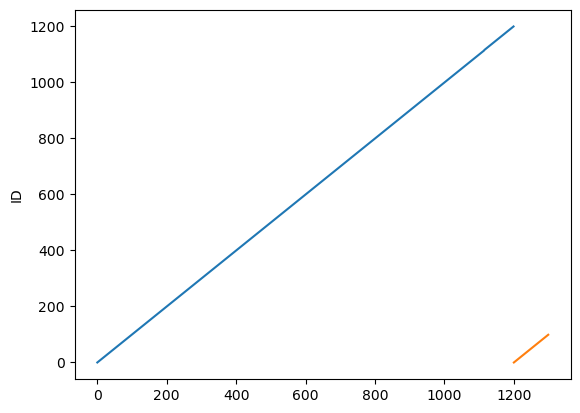

In [80]:
plt.figure()
plt.plot(df_train['ID'])
# plt.figure()
plt.plot(df_val['ID'])
plt.ylabel('ID')

In [83]:
ds_tk_filt_split = datasets.DatasetDict({'train': datasets.Dataset.from_pandas(df_train), 'val': datasets.Dataset.from_pandas(df_val)})
ds_tk_filt_split

DatasetDict({
    train: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 1200
    })
    val: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 100
    })
})

<Axes: xlabel='section_header'>

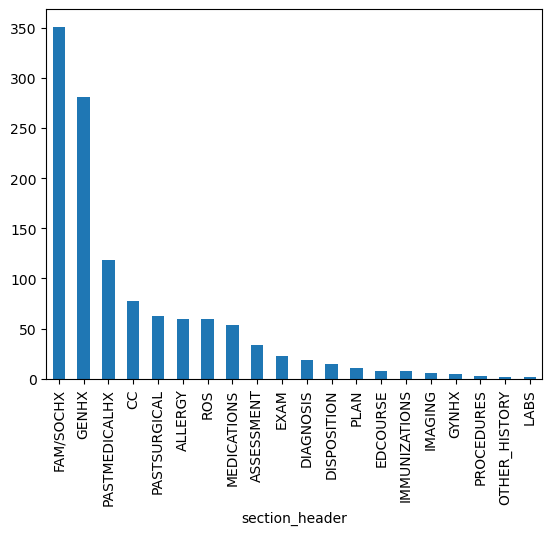

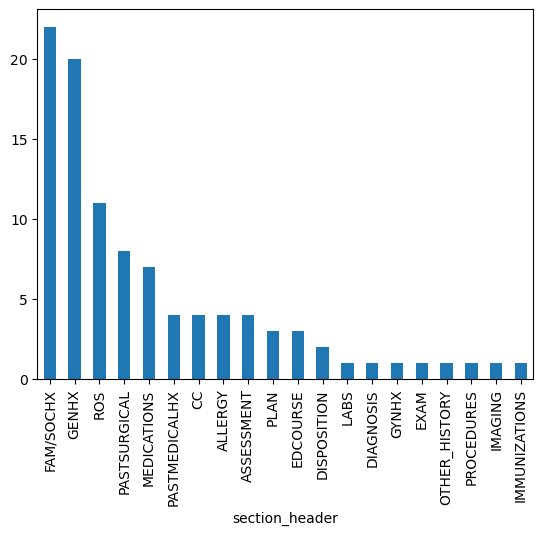

In [84]:
pd.DataFrame(ds_tk_filt_split['train'])['section_header'].value_counts().plot.bar()
plt.figure()
pd.DataFrame(ds_tk_filt_split['val'])['section_header'].value_counts().plot.bar()

In [85]:
print(pd.DataFrame(ds_tk_filt_split['train'])['length'].describe())
print('')
print(pd.DataFrame(ds_tk_filt_split['val'])['length'].describe())

count    1200.000000
mean      160.698333
std       162.782874
min        15.000000
25%        56.000000
50%       100.500000
75%       204.250000
max      1310.000000
Name: length, dtype: float64

count    100.000000
mean     137.710000
std      138.749341
min       15.000000
25%       48.000000
50%       84.000000
75%      168.500000
max      831.000000
Name: length, dtype: float64


Text(0.5, 1.0, 'Val')

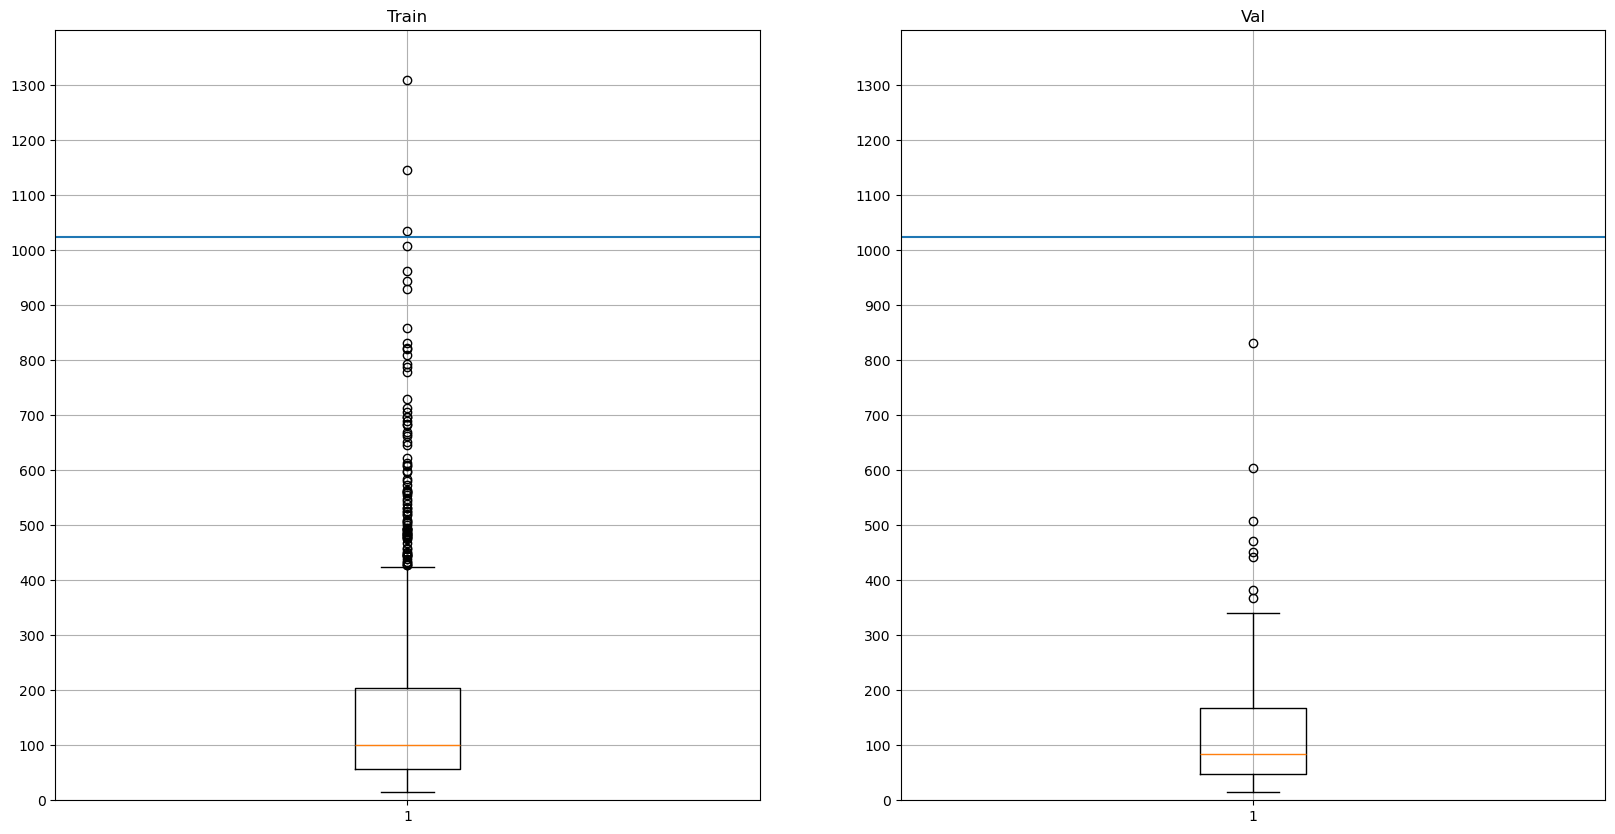

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.boxplot(np.array(pd.DataFrame(ds_tk_filt_split['train'])['length']))
ax1.set_yticks(range(0,1400,100))
ax1.axhline(max_len)
ax1.set_ylim([0, 1400])
ax1.grid()
ax1.set_title('Train')

ax2.boxplot(np.array(pd.DataFrame(ds_tk_filt_split['val'])['length']))
plt.yticks(range(0,1400,100))
ax2.axhline(max_len)
ax2.set_yticks(range(0,1400,100))
ax2.set_ylim([0, 1400])
ax2.grid()
ax2.set_title('Val')

In [87]:
ds_tk_filt_split.push_to_hub('ryanwtsai/MTS_Dialogue-Clinical_Note_OriginalTrainValSplit', private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ryanwtsai/MTS_Dialogue-Clinical_Note_OriginalTrainValSplit/commit/d98797f30ddaf04d81c5f05f55edfde010179cab', commit_message='Upload dataset', commit_description='', oid='d98797f30ddaf04d81c5f05f55edfde010179cab', pr_url=None, pr_revision=None, pr_num=None)

## Train-Test Split

In [95]:
labels = ds_tk_filt['train']['section_header']

In [96]:
train_indices, val_indices = train_test_split(range(len(labels)), test_size=0.2, stratify=labels, random_state=42)

In [97]:
print(len(train_indices))
print(len(val_indices))

1040
260


In [98]:
ds_tk_filt_split = datasets.DatasetDict({'train': ds_tk_filt['train'].select(train_indices), 'val': ds_tk_filt['train'].select(val_indices)})
ds_tk_filt_split

DatasetDict({
    train: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 1040
    })
    val: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 260
    })
})

In [100]:
# pd.DataFrame(ds_tk_filt_split['train'])['section_header'].value_counts()
df_val = pd.DataFrame(ds_tk_filt_split['val'])
df_val_counts = df_val['section_header'].value_counts()
# print(df_val_counts)
valid_list = list(df_val_counts.index[df_val_counts >= 2])
invalid_list = list(df_val_counts.index[df_val_counts < 2])
print(valid_list)
print(invalid_list)
df_val_invalid = df_val[df_val['section_header'].isin(invalid_list)]
df_val_valid = df_val[df_val['section_header'].isin(valid_list)]
df_val_valid['section_header'].value_counts()

labels = df_val_valid['section_header']
val_indices, test_indices = train_test_split(range(len(labels)), test_size=0.5, stratify=labels, random_state=42)
print(len(val_indices))
print(len(test_indices))

['FAM/SOCHX', 'GENHX', 'PASTMEDICALHX', 'CC', 'PASTSURGICAL', 'ROS', 'ALLERGY', 'MEDICATIONS', 'ASSESSMENT', 'EXAM', 'DIAGNOSIS', 'DISPOSITION', 'PLAN', 'EDCOURSE', 'IMMUNIZATIONS']
['LABS', 'IMAGING', 'PROCEDURES', 'GYNHX', 'OTHER_HISTORY']
127
128


In [101]:
df_val = pd.concat((df_val_valid.iloc[val_indices], df_val_invalid))
df_test = df_val_valid.iloc[test_indices]

In [102]:
ds_tk_filt_split['val'] = datasets.Dataset.from_pandas(df_val)
ds_tk_filt_split['test'] = datasets.Dataset.from_pandas(df_test)

In [104]:
ds_tk_filt_split['val'] = ds_tk_filt_split['val'].remove_columns(['__index_level_0__'])
ds_tk_filt_split['test'] = ds_tk_filt_split['test'].remove_columns(['__index_level_0__'])
ds_tk_filt_split

DatasetDict({
    train: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 1040
    })
    val: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 132
    })
    test: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 128
    })
})

<Axes: xlabel='section_header'>

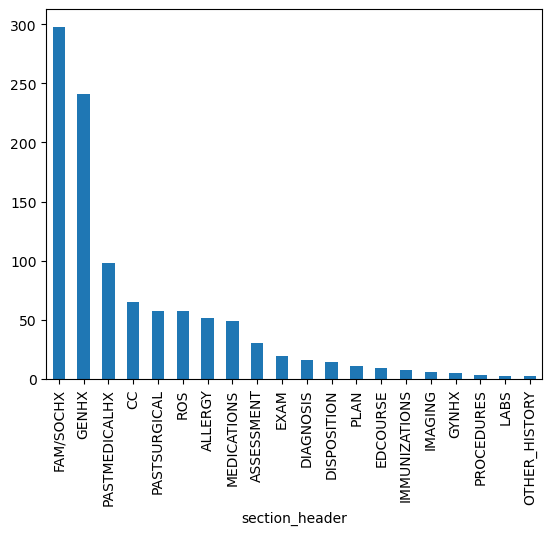

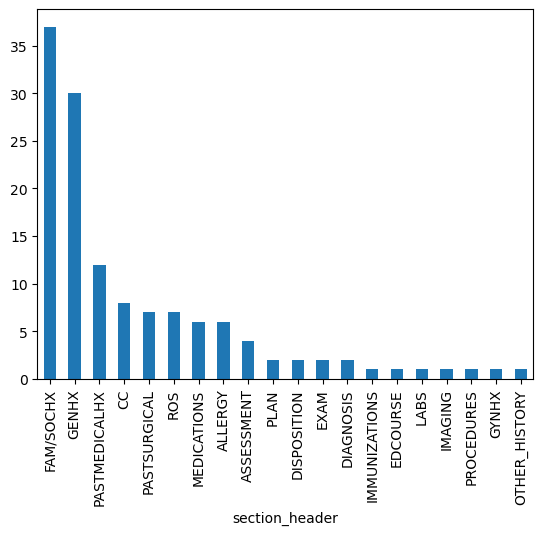

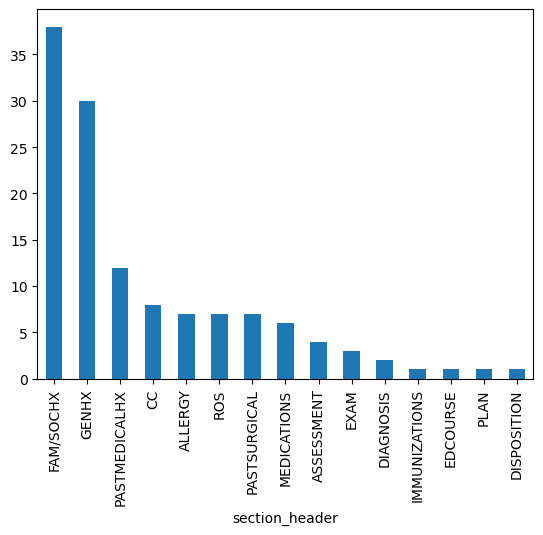

In [105]:
pd.DataFrame(ds_tk_filt_split['train'])['section_header'].value_counts().plot.bar()
plt.figure()
pd.DataFrame(ds_tk_filt_split['val'])['section_header'].value_counts().plot.bar()
plt.figure()
pd.DataFrame(ds_tk_filt_split['test'])['section_header'].value_counts().plot.bar()

In [106]:
print(pd.DataFrame(ds_tk_filt_split['train'])['length'].describe())
print('')
print(pd.DataFrame(ds_tk_filt_split['val'])['length'].describe())
print('')
print(pd.DataFrame(ds_tk_filt_split['test'])['length'].describe())

count    1040.000000
mean      159.389423
std       162.211519
min        15.000000
25%        56.000000
50%        99.500000
75%       201.000000
max      1310.000000
Name: length, dtype: float64

count    132.000000
mean     149.242424
std      150.074339
min       19.000000
25%       58.000000
50%       99.500000
75%      178.250000
max      963.000000
Name: length, dtype: float64

count    128.000000
mean     165.187500
std      164.083652
min       15.000000
25%       53.750000
50%       96.000000
75%      240.000000
max      794.000000
Name: length, dtype: float64


In [ ]:
# plt.figure(figsize=(8,10))
# pd.DataFrame(ds_tk_filt_split['train']).boxplot(column='length')
# plt.yticks(range(0,1400,100))
# plt.axhline(1024)
# plt.ylim([0, 1400])

# plt.figure(figsize=(8,10))
# pd.DataFrame(ds_tk_filt_split['val']).boxplot(column='length')
# plt.yticks(range(0,1400,100))
# plt.axhline(1024)
# plt.ylim([0, 1400])

# plt.figure(figsize=(8,10))
# pd.DataFrame(ds_tk_filt_split['test']).boxplot(column='length')
# plt.yticks(range(0,1400,100))
# plt.axhline(1024)
# plt.ylim([0, 1400])

Text(0.5, 1.0, 'Test')

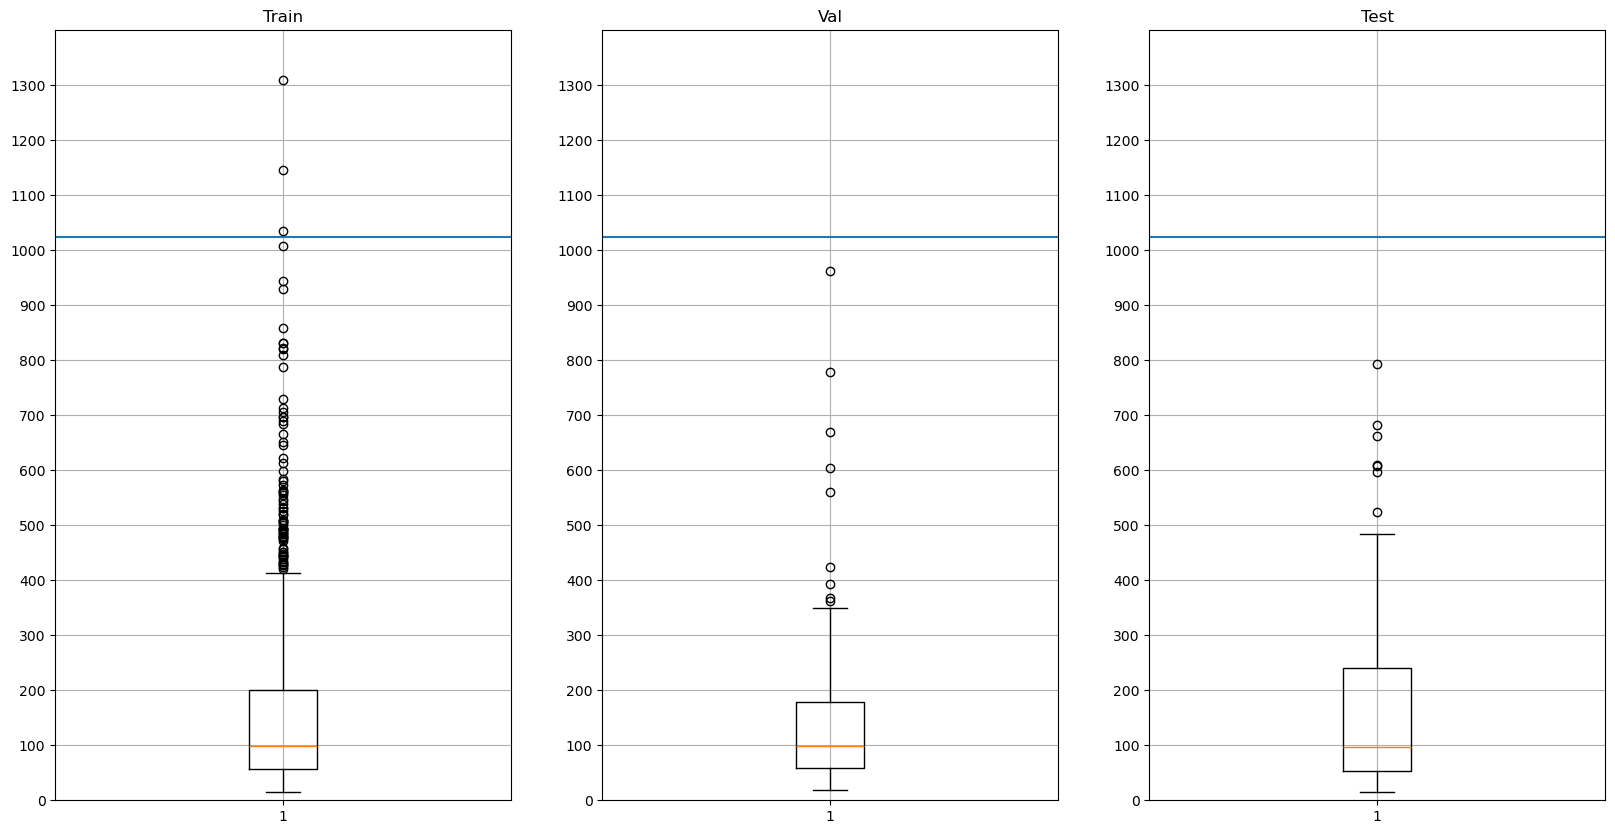

In [110]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.boxplot(np.array(pd.DataFrame(ds_tk_filt_split['train'])['length']))
ax1.set_yticks(range(0,1400,100))
ax1.axhline(max_len)
ax1.set_ylim([0, 1400])
ax1.grid()
ax1.set_title('Train')

ax2.boxplot(np.array(pd.DataFrame(ds_tk_filt_split['val'])['length']))
plt.yticks(range(0,1400,100))
ax2.axhline(max_len)
ax2.set_yticks(range(0,1400,100))
ax2.set_ylim([0, 1400])
ax2.grid()
ax2.set_title('Val')

ax3.boxplot(np.array(pd.DataFrame(ds_tk_filt_split['test'])['length']))
plt.yticks(range(0,1400,100))
ax3.axhline(max_len)
ax3.set_yticks(range(0,1400,100))
ax3.set_ylim([0, 1400])
ax3.grid()
ax3.set_title('Test')

In [120]:
IDs = list(ds_tk_filt_split['train']['ID']) + list(ds_tk_filt_split['val']['ID']) + list(ds_tk_filt_split['test']['ID'])

In [132]:
IDs = np.sort(np.array(IDs))
print(min(np.diff(IDs)))
print(max(np.diff(IDs)))
diff = np.diff(IDs)
np.nonzero(diff == 2)
IDs[1110:1120]
# Right, we removed ID 1115

1
2


array([1110, 1111, 1112, 1113, 1114, 1116, 1117, 1118, 1119, 1120])

In [137]:
ds_tk_filt_split['train'] = datasets.Dataset.from_pandas(pd.DataFrame(ds_tk_filt_split['train']))

In [ ]:
# ds_tk_filt_split['train'] = ds_tk_filt_split['train'].cast(Features({'ID': Value(dtype='int64', id=None), 'section_header': Value(dtype='string', id=None), 'section_text': Value(dtype='string', id=None), 'dialogue': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'length': Value(dtype='int32', id=None), 'labels': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None)}))

In [154]:
print(ds_tk_filt_split['train'].features)

{'ID': Value(dtype='int64', id=None), 'section_header': Value(dtype='string', id=None), 'section_text': Value(dtype='string', id=None), 'dialogue': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'length': Value(dtype='int64', id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


In [139]:
ds_tk_filt_split.push_to_hub('ryanwtsai/MTS_Dialogue-Clinical_Note_TrainValTestSplit', private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ryanwtsai/MTS_Dialogue-Clinical_Note_TrainValTestSplit/commit/240fbacaa31924f3934fb5d82095b3c40d016041', commit_message='Upload dataset', commit_description='', oid='240fbacaa31924f3934fb5d82095b3c40d016041', pr_url=None, pr_revision=None, pr_num=None)

## StratifiedKFold

In [237]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [241]:
labels = ds_tk_filt['train']['section_header']
ds_tk_filt_kfold = {}
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(np.zeros(ds_tk_filt['train'].num_rows), labels)):
    ds_tk_filt_kfold[f"fold{fold_idx}"] = datasets.DatasetDict({'train': ds_tk_filt['train'].select(train_idx), 'val': ds_tk_filt['train'].select(val_idx)})

C:\ProgramData\anaconda3\envs\env_dl_cv_transformer_sentpiece\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [242]:
ds_tk_filt_kfold

{'fold0': DatasetDict({
     train: Dataset({
         features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
         num_rows: 1040
     })
     val: Dataset({
         features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
         num_rows: 260
     })
 }),
 'fold1': DatasetDict({
     train: Dataset({
         features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
         num_rows: 1040
     })
     val: Dataset({
         features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
         num_rows: 260
     })
 }),
 'fold2': DatasetDict({
     train: Dataset({
         features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
         num_rows: 1040
     })
     val: Dataset({
         featu